# Image quality
Investigation into image quality with PSNR. Produces plots for Figure 4 and stats in section 3.2.1 and 3.2.2.

In [22]:
import os

import bids
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from dataframe_help import add_subject_lines, add_temperature_w0_sw, make_global_group_comparison
from stats_help import check_model, bootstrap_validate

sns.set_theme()

In [23]:
# Load data
df_par = pd.read_csv('../data/session_params.csv').drop(columns=['Unnamed: 0'])
df = pd.read_csv('../data/PSNR_df.csv').drop(columns=['index'])

df = add_temperature_w0_sw(df, '../data/')
df = df.drop(df[df['PSNR'] == np.inf].index).reset_index()
df['mod_PSNR'] = 10**(df['PSNR']/10)

Adding in temperature, w0 and SW: 100%|██████████| 242/242 [00:00<00:00, 1639.65it/s]


## Figure 4: Correlation between temperature and Larmor frequency

/Users/emil/miniforge3/envs/qa_paper/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)




------ w0 ~ Temperature ------
MixedLM -> Intercept: 2.74529 (p=0.00e+00)
OLS -> Intercept: 2.69707 (p=3.99e-177)
MixedLM -> Temperature: -0.00140 (p=8.61e-33)
OLS -> Temperature: 0.00078 (p=2.44e-01)
MixedLM -> Group Var: 73.83354 (p=1.52e-02)


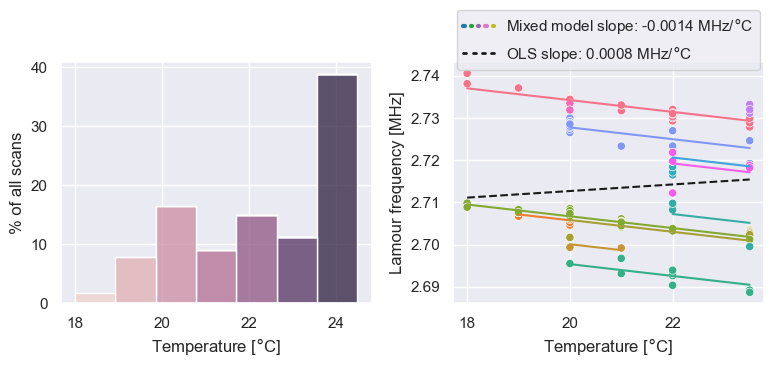

In [26]:
# Paper figure
fig, axes = plt.subplots(1,2, figsize=(8,4))

sns.histplot(df, x='Temperature', hue='Temperature', multiple='stack', bins=7, stat='percent', legend=False, ax=axes[0])
axes[0].set_ylabel('% of all scans')
axes[0].set_xlabel(r'Temperature [$\degree$C]')

### w0 ~ Temperature ###
ax = axes[1]
filt_df = df[df.Temperature<24.5]

xlm_model = smf.mixedlm("w0 ~ Temperature", filt_df, groups=filt_df['Subject'])
xlm_res = xlm_model.fit(method=['lbfgs'])

ols_model = smf.ols("w0 ~ Temperature", filt_df)
ols_res = ols_model.fit()

sns.scatterplot(data=filt_df, x='Temperature', y='w0', hue='Subject', ax=ax)
x = np.linspace(filt_df['Temperature'].min(),filt_df['Temperature'].max())

ax.plot(x, ols_res.params['Intercept'] + x*ols_res.params['Temperature'], '--k')
ax.legend([])
add_subject_lines(ax, filt_df, xlm_res, 'Temperature')

print("\n\n------ w0 ~ Temperature ------")
for k in xlm_res.params.keys():
    print(f"MixedLM -> {k}: {xlm_res.params[k]:.5f} (p={xlm_res.pvalues[k]:.2e})")
    try:
        print(f"OLS -> {k}: {ols_res.params[k]:.5f} (p={ols_res.pvalues[k]:.2e})")
    except:
        continue

ax.set_ylabel('Lamour frequency [MHz]')
ax.set_xlabel(r'Temperature [$\degree$C]')
ax.legend().remove()

mixedmodel_line = [Line2D([0], [0], color=plt.cm.tab10(i/100), lw=3) for i in range(0, 100, 20)]
ols_line = [Line2D([0], [0], color='k', lw=2) for i in range(0, 100, 30)]

ax.legend([(tuple(mixedmodel_line)),(tuple(ols_line))], 
          [rf"Mixed model slope: {xlm_res.params['Temperature']:.4f} MHz/$\degree$C", 
           rf"OLS slope: {ols_res.params['Temperature']:.4f} MHz/$\degree$C"], 
          handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=1)

plt.tight_layout()
plt.savefig('../results/figure4_temperature_w0.png', dpi=300)
plt.show()

## Figure 5: PSNR violin plot and image examples
Cannot be fully reproduced without source data which, unfortunately, isn't shared

In [27]:
# Used to load local data with the images to display. Not available publicly
projdir = '/Users/emil/Projects/QA/CaliberPaper/lunarc/QA_paper/project'
if os.path.exists(projdir):
    print("Indexing BIDS structure")
    use_bids = True
    layout = bids.BIDSLayout(root=projdir+'/rawdata', derivatives=projdir+'/derivatives')
else:
    print("Reproducing figures without source data")
    use_bids = False

Indexing BIDS structure


/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_89789/2112069991.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


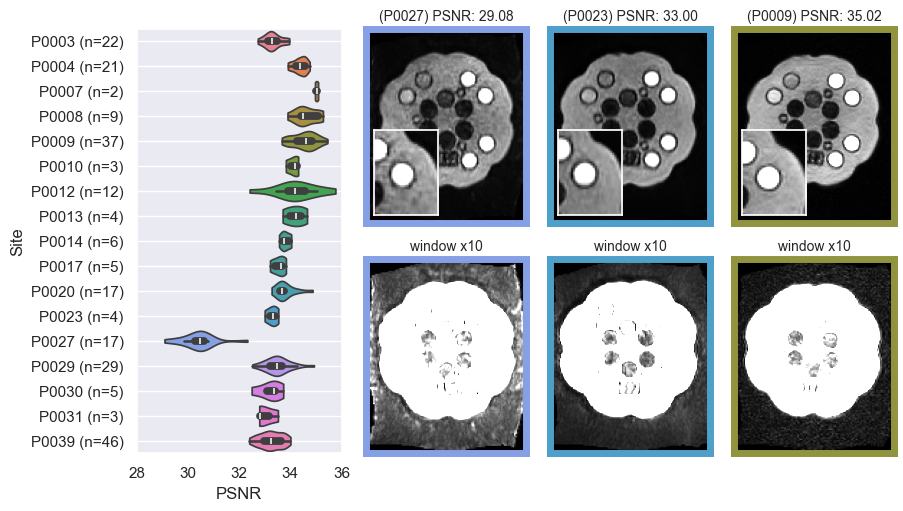

In [28]:
# Example images with different PSNR
my_psnr = [28,30,31,33,34,35]
my_psnr = [28,33,35]
id_psnr = []
for psnr in my_psnr:
    id_psnr.append((df['PSNR']-psnr).abs().idxmin())

sns.set_theme()
fig = plt.figure(constrained_layout=True, figsize=(9,5))
widths = [3.5,3,3,3]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths)
ax = fig.add_subplot(spec[:,0])
violin_ax = ax
violin = sns.violinplot(data=df, y='Subject', x='PSNR', hue='Subject',  alpha=1, orient='h', cut=0)

ax.set_ylabel('Site')
ax.set_xlabel('PSNR')
ax.grid()
ax.set_xlim([28,36])

violin_colors = {}
for i, artist in enumerate(violin.collections):  # Step by 2 to skip the violin bodies
    facecolor = artist.get_facecolor().tolist()[0]  # Get the RGBA face color
    x_label = ax.get_yticklabels()[i].get_text()  # Get the corresponding x-label
    violin_colors[x_label] = facecolor

if use_bids:
    for i in range(3):
        row, col = np.unravel_index(i, [2,3])
        ax = fig.add_subplot(spec[row, col+1])
        row = df.loc[id_psnr[i]]
        img = layout.get(scope='raw', extension='.nii.gz', subject=row.Subject, reconstruction='axi', session=row.Session, run=1)[0].get_image().get_fdata()
        img /= np.mean(img)
        ax.imshow(np.rot90(img[:,:,14]), cmap='gray', vmax=6)
        
        zoomed_img = img[70:100, 70:110, 14]
        ax_inset = ax.inset_axes([0.05, 0.01, 0.4, 0.5])
        ax_inset.imshow(np.rot90(zoomed_img), cmap='gray', vmax=6)
        ax_inset.set_xticklabels([]); ax_inset.set_yticklabels([]); ax_inset.grid(None)
        
        ax.set_title(f'({row.Subject}) PSNR: {row.PSNR:.2f}', size=10)
        ax.set_xticklabels([]); ax.set_yticklabels([]); ax.grid(None)
        for spine in ax.spines.values():
            spine.set_edgecolor(violin_colors[row.Subject])  # Set the color of the frame
            spine.set_linewidth(5)        # Set the width of the frame

        row, col = np.unravel_index(i+3, [2,3])
        ax = fig.add_subplot(spec[row, col+1])
        row = df.loc[id_psnr[i]]
        ax.imshow(np.rot90(img[:,:,14]), cmap='gray', vmax=0.6)

        ax.set_title(f'window x10', size=10)
        ax.set_xticklabels([]); ax.set_yticklabels([]); ax.grid(None)
        for spine in ax.spines.values():
            spine.set_edgecolor(violin_colors[row.Subject])  # Set the color of the frame
            spine.set_linewidth(5)        # Set the width of the frame

new_labels = []

ax = violin_ax
for i in range(17):  # Step by 2 to get the violin bodies
    x_label = ax.get_yticklabels()[i].get_text()  # Get the corresponding y-label
    count = df[df['Subject'] == x_label].shape[0]  # Get the count of data points for this label
    new_labels.append(f'{x_label} (n={count})')

ax.set_yticklabels(new_labels)
# plt.tight_layout()

plt.savefig('../results/figure5_PSNR_image.png', dpi=300)
plt.show()

In [34]:
# Summary of PSNR
print(f"--- PSNR summary ---")
print(f"Min: {df['PSNR'].min():.3f}\nMax: {df['PSNR'].max():.3f}\nMean: {df['PSNR'].mean():.3f} ")

PSNR_anova = sm.stats.anova_oneway(df.PSNR, groups=df.Subject)
print(f"\nANOVA PSNR between site. p={PSNR_anova.pvalue:.2e}")

--- PSNR summary ---
Min: 29.084
Max: 35.760
Mean: 33.573 

ANOVA PSNR between site. p=5.60e-17


## Statistics

### Stats section 3.2.2 Expanded correlation model
To check which factors that PSNR is predicted by we run a multiple regression model to see which factors that are significant predictors (through anova analysis). Since we don't know if our variables are normally distributed we run a bootstrap validation of the model as well

------- mod_PSNR -------
                           sum_sq     df          F        PR(>F)
C(SoftwareVersions)  7.421387e+06    5.0  46.882477  2.043084e-27
C(Subject)           1.039057e+07   13.0  25.245927  2.449986e-29
Temperature          1.285744e+06    1.0  40.611589  3.015749e-09
Residual             4.084080e+06  129.0        NaN           NaN
---- Auto correlation ----
Durbin-Watson Test: 2.030 (Close to 2 is good)

---- Check if variance depends on parameter value ----
Lagrange multiplier statistic: 19.4151 (p-value: 0.4305)
f-statistic of the hypothesis that the error variance does not depend on x: 1.0821 (p-value: 0.3773)

----Shapiro-Wilk Test for normality ----
Stat: 0.974 pvalue: 0.007103572687182483


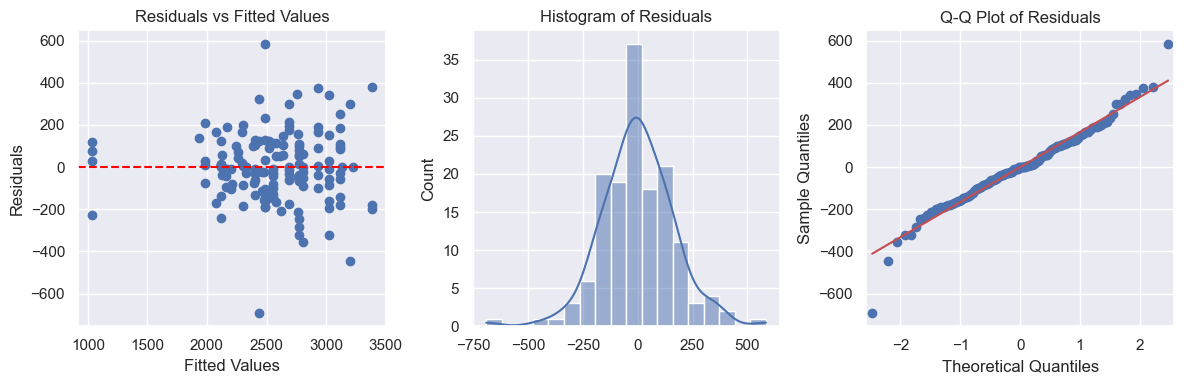

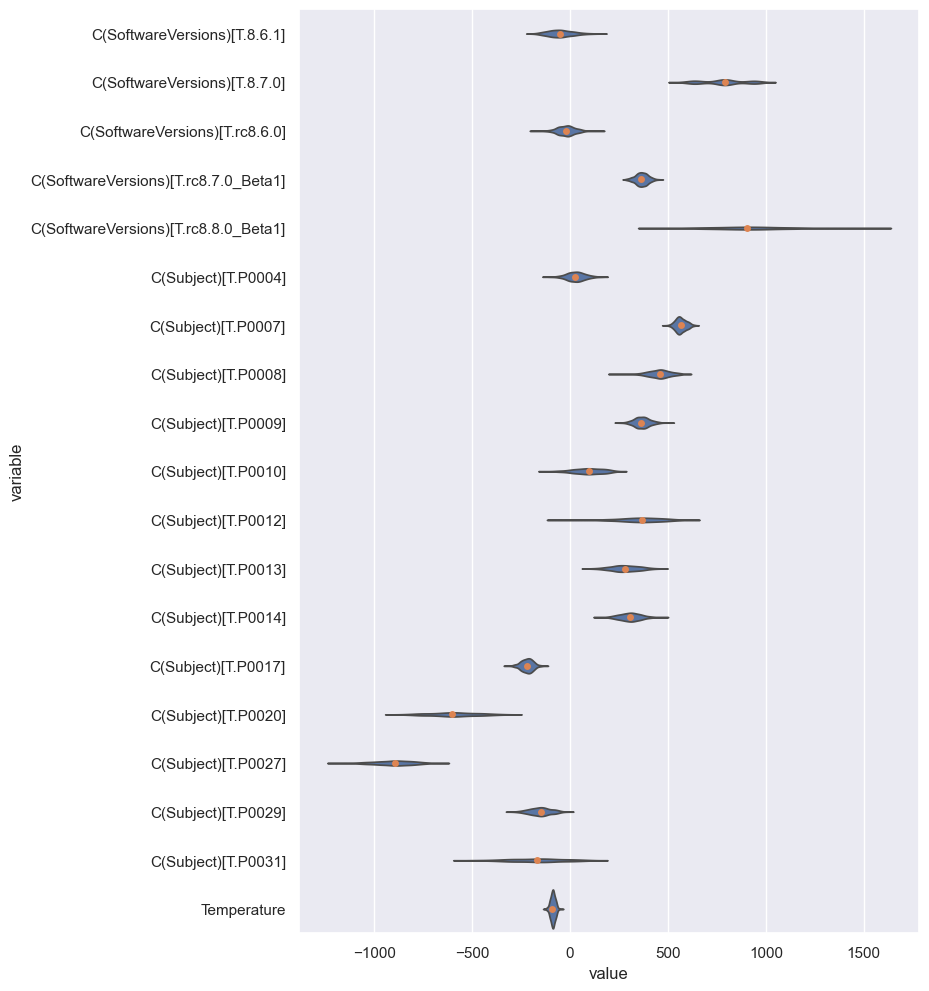

In [ ]:
print("------- mod_PSNR -------")
filt_df = df[df.Temperature < 24.5]
formula = 'mod_PSNR ~ Temperature + C(SoftwareVersions) + C(Subject)'
model = smf.ols(formula, data=filt_df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)
check_model(model)
bootstrap_validate(filt_df, model, formula, num_bootstrap=500)

#### Additional figures

-------------- w0 --------------
OLS params
Intercept: 61799.10968 (p=4.60e-17)
Slope: -21831.99634 (p=4.74e-16)

Mixed params
Intercept: -56386.14691 (p=8.70e-02)
Slope: 21671.24329 (p=7.41e-02)


-------------- Temperature --------------
OLS params
Intercept: 5618.38303 (p=3.89e-25)
Slope: -145.13502 (p=1.54e-10)

Mixed params
Intercept: 4902.90018 (p=2.32e-33)
Slope: -113.39492 (p=3.12e-10)




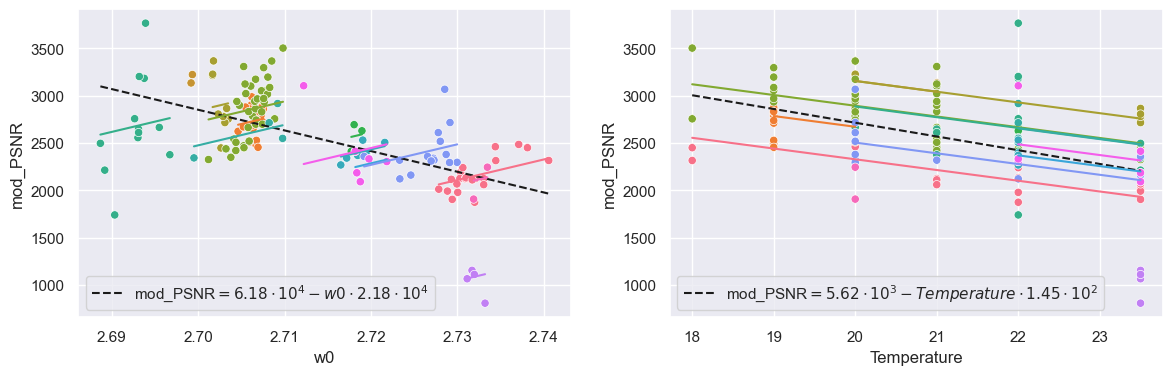

In [12]:
fig, axes = plt.subplots(1,2,figsize=(14,4))
res_lm = {}
res_ol = {}
ax, xlm_res, ols_res = make_global_group_comparison(filt_df, axes[0],'w0', 'mod_PSNR', filter_temp=False)
res_lm['w0'] = xlm_res
res_ol['w0'] = ols_res

ax, xlm_res, ols_res = make_global_group_comparison(filt_df, axes[1],'Temperature', 'mod_PSNR', filter_temp=False)
res_lm['Temperature'] = xlm_res
res_ol['Temperature'] = ols_res

for x in ['w0', 'Temperature']:
    print(f"-------------- {x} --------------")
    print("OLS params")
    print(f"Intercept: {res_ol[x].params['Intercept']:.5f} (p={res_ol[x].pvalues['Intercept']:.2e})")
    print(f"Slope: {res_ol[x].params[x]:.5f} (p={res_ol[x].pvalues[x]:.2e})")

    print("\nMixed params")
    print(f"Intercept: {res_lm[x].params['Intercept']:.5f} (p={res_lm[x].pvalues['Intercept']:.2e})")
    print(f"Slope: {res_lm[x].params[x]:.5f} (p={res_lm[x].pvalues[x]:.2e})")

    print('\n')


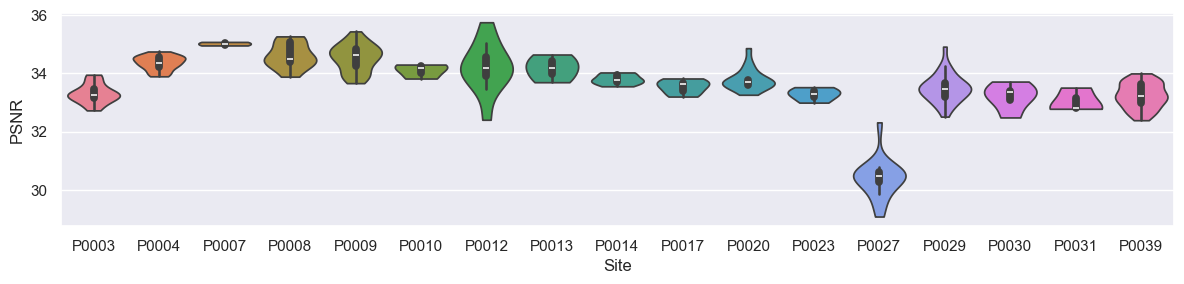

Anova PSNR between site. p=5.60e-17


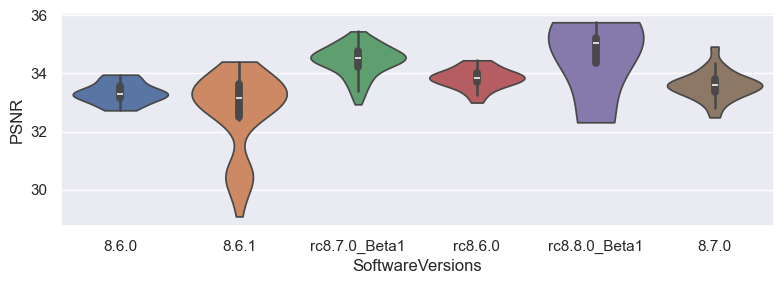

Anova PSNR between SW. p=3.17e-11


In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

sns.violinplot(data=df, x='Subject', y='PSNR', hue='Subject',  alpha=1, cut=0, ax=ax)
ax.set_xlabel('Site')
plt.tight_layout()
plt.show()

PSNR_anova = sm.stats.anova_oneway(df.PSNR, groups=df.Subject)
print(f"Anova PSNR between site. p={PSNR_anova.pvalue:.2e}")

fig, ax = plt.subplots(1,1,figsize=(8,3))

sns.violinplot(data=df, x='SoftwareVersions', y='PSNR', hue='SoftwareVersions',  alpha=1, cut=0, ax=ax)
ax.set_xlabel('SoftwareVersions')
plt.tight_layout()
plt.show()

PSNR_anova = sm.stats.anova_oneway(df.PSNR, groups=df.SoftwareVersions)
print(f"Anova PSNR between SW. p={PSNR_anova.pvalue:.2e}")



## Figure S4: Simulation of how PSNR relates to classic SNR measurements
This part also requires you to have the `ghost` repository installed.

In [14]:
import ants
from tqdm import tqdm 

from ghost.phantom import Caliber137
from ghost.utils import calc_psnr, calc_snr_diff

In [15]:
def add_rician_noise(data, sd, rng):
    noise = rng.normal(0, sd, [*data.shape, 2])
    return np.sqrt( abs(data + noise[...,0])**2 + abs(1j*noise[...,1])**2)

In [16]:
phantom = Caliber137()

fname = phantom.get_phantom_nii(weighting='T2w')
data = ants.image_read(fname)

fname = phantom.get_seg_nii('phantomMask')
seg = ants.image_read(fname)

fname = phantom.get_seg_nii('BG')
BG = ants.image_read(fname)

In [17]:
# Downsample and scale data
data_rs = ants.resample_image(data, [1.5, 1.5, 5], interp_type=0, use_voxels=False).numpy()
data_rs /= np.max(data_rs)

seg_rs = ants.resample_image(seg, [1.5, 1.5, 5], interp_type=1, use_voxels=False).numpy()
seg_rs[seg_rs==0] = np.nan

BG_rs = ants.resample_image(BG, [1.5, 1.5, 5], interp_type=1, use_voxels=False).numpy()
BG_rs[BG_rs==0] = np.nan

# Crop images to save time
data_rs = data_rs[25:-25, 25:-25, 1:-4]
seg_rs = seg_rs[25:-25, 25:-25, 1:-4]
BG_rs = BG_rs[25:-25, 25:-25, 1:-4]

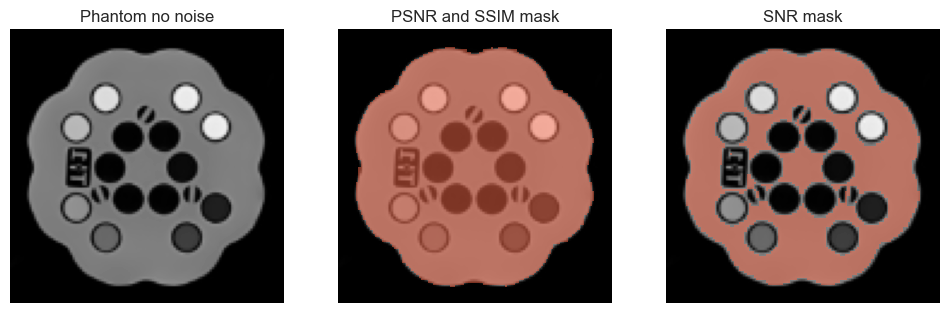

In [18]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

axes[0].imshow(data_rs[:,:,20], cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Phantom no noise')

axes[1].imshow(data_rs[:,:,20], cmap='gray', vmin=0, vmax=1)
axes[1].imshow(seg_rs[:,:,20], cmap='Reds', vmin=0, vmax=2, alpha=0.5)
axes[1].set_title('PSNR and SSIM mask')

axes[2].imshow(data_rs[:,:,20], cmap='gray', vmin=0, vmax=1)
axes[2].imshow(BG_rs[:,:,20], cmap='Reds', vmin=0, vmax=2, alpha=0.5)
axes[2].set_title('SNR mask')

for ax in axes:
    ax.axis('off')

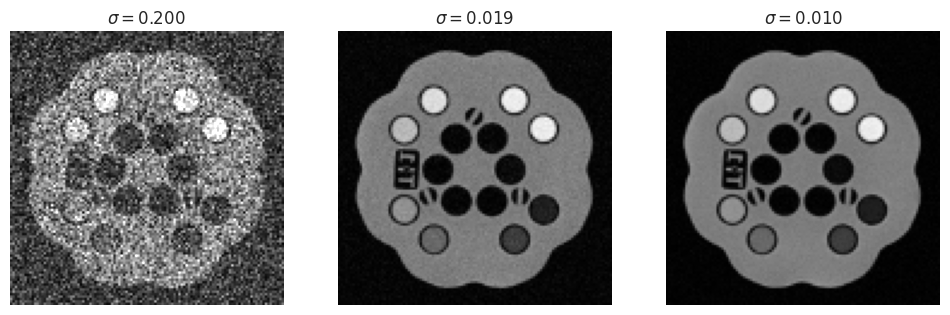

In [19]:
rng = np.random.default_rng(seed=42)
n_noise = 50
noise_levels = np.linspace(5,100, num=n_noise)
ns = noise_levels[[0,n_noise//2, n_noise-1]]

fig, axes = plt.subplots(1,3,figsize=(12,4))
for i in range(len(ns)):
    img1 = add_rician_noise(data_rs, 1/ns[i], rng)
    axes[i].imshow(img1[:,:,20], vmin=0, vmax=1, cmap='gray')
    axes[i].set_title(fr'$\sigma={1/ns[i]:.3f}$')
    axes[i].axis('off')


In [20]:
n_iter = 100

mat_psnr = np.zeros([n_iter, len(noise_levels)])
mat_psnr_ref = np.zeros_like(mat_psnr)
mat_snr = np.zeros_like(mat_psnr)

for i,s in tqdm(enumerate(noise_levels)):
    for k in range(n_iter):
        img1 = add_rician_noise(data_rs, 1/s, rng)
        img2 = add_rician_noise(data_rs, 1/s, rng)

        MSE, PSNR = calc_psnr(img1, img2, seg_rs)
        _, PSNR_ref = calc_psnr(data_rs, img2, seg_rs)

        SNR = calc_snr_diff(img1, img2, BG_rs)
        
        mat_psnr[k,i] = PSNR
        mat_psnr_ref[k,i] = PSNR_ref
        mat_snr[k,i] = SNR
        

50it [03:16,  3.93s/it]


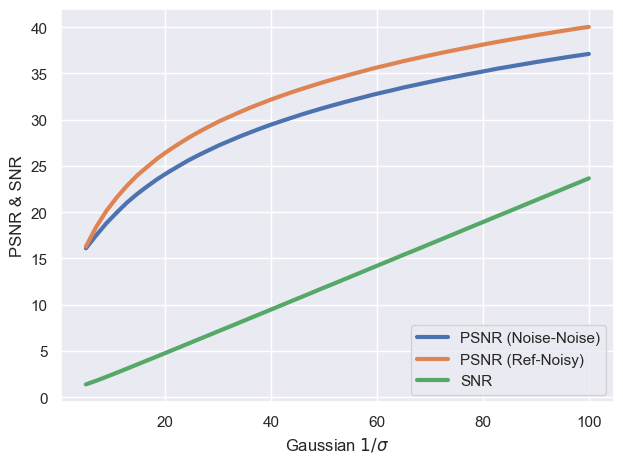

In [21]:
sns.set_theme()

fig, axes = plt.subplots(1,1)
ax = axes
ax.plot(noise_levels, np.mean(mat_psnr, axis=0), linewidth=3, label='PSNR (Noise-Noise)')
ax.plot(noise_levels, np.mean(mat_psnr_ref, axis=0), linewidth=3, label='PSNR (Ref-Noisy)')
ax.plot(noise_levels, np.mean(mat_snr, axis=0), linewidth=3, label='SNR')

ax.set_ylabel('PSNR & SNR')
ax.set_xlabel(r'Gaussian $1/\sigma$')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../results/figureS4_SNR_simulation.png', dpi=300)
plt.show()